In [2]:
# kiểm tra Keras có đang sử dụng GPU không
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [8]:
from keras.datasets.cifar10 import load_data
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

**CIFAR-10** là một dataset bao gồm 60,000 bức ảnh màu có kích thước 32x32 chứa hình ảnh của các đối tượng từ 10 class, chẳng hạn như ếch, chim, mèo, tàu thủy, máy bay,...

Keras cũng cung cấp dataset này thông qua lệnh dưới đây:

In [4]:
(trainX, trainy), (testX, testy) = load_data()

print(f"Train shape: X - {trainX.shape}, y - {trainy.shape}.")
print(f" Test shape: X - {testX.shape}, y - {testy.shape}.")

Train shape: X - (50000, 32, 32, 3), y - (50000, 1).
 Test shape: X - (10000, 32, 32, 3), y - (10000, 1).


Chúng ta có thể hiện thị vài mẫu trong dataset này.

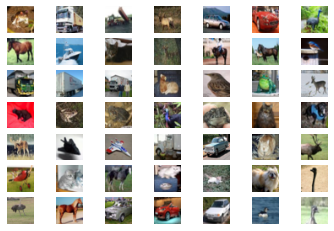

In [6]:
for i in range(49):
    plt.subplot(7, 7, i + 1)
    plt.axis('off')
    plt.imshow(trainX[i])
    
plt.show()

Chúng ta sẽ sư dụng dataset này để đào tạo một DCGANs model, cụ thể DCGANs model của chúng ta sẽ bao gồm hai model con là Generator model và Discriminator model, trong đó:
  * **Generator model**: học cách tạo ra các bức ảnh (gọi là **generated sample**, còn được gọi là **fake sample**) sao cho nhìn nó thật nhất có thể.
  * **Discriminator model**: phân biệt giữa **fake sample** và **real sample** với real sample được lấy từ CIFAR-10.  

# Định nghĩa cho Discriminator model

Bước đầu tiên là ta cần định nghĩa cho discriminator model. Model này sẽ nhận vào một sample image và cố gắng dự đoán nó xem nó là real hay fake sample. Đây cũng được coi là một binary classification model.
  * **Inputs**: image gồm 3 channel có size là 32x32
  * **Outputs**: phân loại nhị phân, dự đoán sample là real hay fake.

Kiến trúc của discriminator bao gồm:
  * **3 normal convolutional layer** với `stride=(2, 2)` dùng để downsample input image, ta sử dụng các layer này để thay thế cho các **Pooling layers**.
  * **1 output layer** bao gồm 1 neuron và sử dụng **sigmoid activation function** để dự đoán sample image là real hay fake.
  * Sử dụng **binary cross-entropy** loss function.
  * Và thay vì sử dụng **ReLU**, ta sẽ sử dụng **LeakyReLU**.
  * Ta cũng sử dụng thêm **Dropout layer** để chống overfitting.
  * Optimizater mà ta sử dụng là **Adam** với hai tham số **learning rate** và **momentum** được điều chỉnh lần lượt là $0.0002$ và $0.5$.

Mọi thiệt lập bên trên được đề nghị bởi người phát sinh ra DCGANs - Radford trong bài báo Deep Convolutional Generative Adversarial Networks vào năm 2015 sau khi nhiều lần tiến hành thử và sai để tìm ra một cấu trúc phù hợp, nhằm xây dựng một GANs model ổn định hơn. Dưới đây là hình chụp gốc từ đề nghị của tác giả:<br>
  ![](./images/00.png)

Ngoài ra, nếu ta muốn tìm hiểu rõ ràng hơn về các khuyến nghị trên thì có thể xem bài viết từ Soumith Chintala - đồng tác giả của DCGANs với một bài viết trên [**Github**](https://github.com/soumith/ganhacks) và video trình bày chi tiết tại [**Youtube**](https://www.youtube.com/watch?v=X1mUN6dD8uE). Đây là những tips dùng để hack GANs model để tăng tính ổn định của nó.

Bây giờ, ta sẽ thiết lập tất cả bên trong một hàm là `define_discriminator()`.

In [9]:
def define_discriminator(in_shape=(32, 32, 3)):
    """
    Hàm này dùng để định nghĩa một Discriminator model độc lập.

    Args:
        in_shape (tuple, optional): Là sample image 3 kênh màu, có size là 32x32.
    """
    model = Sequential()
    
    '''Normal'''
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    '''Downsample'''
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    '''Downsample'''
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    '''Classifier'''
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    '''Compile'''
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

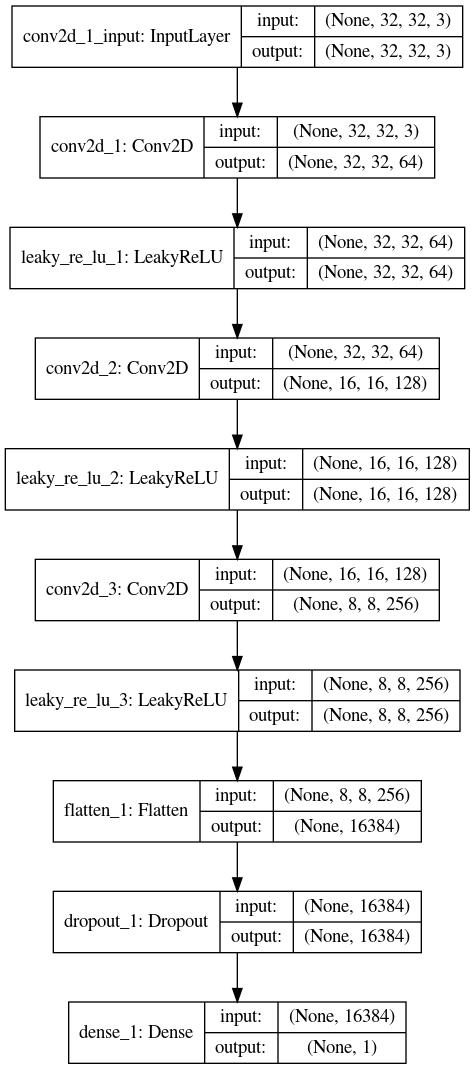

In [10]:
model = define_discriminator()
model.summary()
plot_model(model, to_file="./images/discriminator_plot.png",
           show_shapes=True, show_layer_names=True)

> **Nhận xét**:
> * Ở `conv2d_1 (Conv2D)` ta có $1792$ params là do ta dùng 64 neuron, kernel có size 3x3 và sample image có 3 channel, ngoài ra ta phải công thêm 1 là bias nên số param cho layer này là $64 * (3*3*3 + 1) = 1792$.
> * Ở `conv2d_2 (Conv2D)` ta có $73856$ params là từ 64 neurons của layer trước đó và 128 neuron ở chính lớp này, kernel size là 3x3 và 128 giá trị bias, nên số param là $64 * 128 * 3 * 3 + 128 = 73856$.
> * Ở `conv2d_3 (Conv2D)` ta tính tương tự như trên tức $128 * 256 * 3 * 3 + 256 = 295168$.
> * Ở `dense_1 (Dense)`, do trước đó có **Flatten layer** và ta cần cộng thêm 1 bias cho chính layer này nên ta được $256 * 8 * 8 + 1 = 16385$.